**ETE III - LAB TEST**   
**Arunoth Symen A - 2347215**

**Question 1 - LSTM Autoencoder**     
*Objective:*     
You are required to build an LSTM Autoencoder to detect anomalies in a time series dataset. The dataset contains daily temperature readings from a weather station over the course of a few years. Parameters in the dataset [Date and Temperature]

Importing the required libraries

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from keras.models import Sequential
from keras.layers import LSTM, Dense, RepeatVector, TimeDistributed
from keras import backend as K

1. Load the dataset: The dataset will contain a single column temperature and a date column.

In [ ]:
# Step 1: Load the dataset from CSV

file_path = '/content/weather_data.csv'
df = pd.read_csv(file_path)

# Ensure the 'date' column is in datetime format
df['date'] = pd.to_datetime(df['date'])
df.set_index('date', inplace=True)
df.head()

,temperature
date,
2014-01-01,10.248357
2014-01-02,9.950428
2014-01-03,10.362958
2014-01-04,10.820167
2014-01-05,9.961091


2. Preprocess the data: Normalize the temperature data and split it into training and testing
sets.

Preprocessing:

* The temperature data was normalized for efficient training.   
* Data was split into training and testing sets while maintaining time-series integrity.

In [ ]:
# Step 2: Preprocess the data
scaler = MinMaxScaler()
df['temperature_normalized'] = scaler.fit_transform(df[['temperature']])

# Prepare sequences for LSTM
def create_sequences(data, sequence_length):
    sequences = []
    for i in range(len(data) - sequence_length + 1):
        seq = data[i:i + sequence_length]
        sequences.append(seq)
    return np.array(sequences)

sequence_length = 5
sequences = create_sequences(df['temperature_normalized'].values, sequence_length)

# Split into training and testing sets
train_size = int(0.7 * len(sequences))
train_data = sequences[:train_size]
test_data = sequences[train_size:]

In [ ]:
train_data.shape

(1787, 5)

In [ ]:
test_data.shape

(766, 5)

3. Build an LSTM Autoencoder:

    The encoder should reduce the input dimensions to a latent representation.

    The decoder should reconstruct the input from the latent representation.

In [ ]:
# Step 3: Build the LSTM Autoencoder
model = Sequential([
    LSTM(64, activation='relu', input_shape=(sequence_length, 1), return_sequences=True),
    LSTM(32, activation='relu', return_sequences=False),
    RepeatVector(sequence_length),
    LSTM(32, activation='relu', return_sequences=True),
    LSTM(64, activation='relu', return_sequences=True),
    TimeDistributed(Dense(1))
])
model.compile(optimizer='adam', loss='mse')


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


4. Train the model: Train the autoencoder on the training data and evaluate the
reconstruction error on the test set.

**Training Process**   
*Loss Values:*
The model was trained over 50 epochs, and both the training loss and validation loss decreased consistently, stabilizing towards the end. This indicates the model learned effectively and generalized well to the validation data.    
*Final Validation Loss:*
The final validation loss is approximately 0.000977. This suggests the autoencoder is reconstructing normal (non-anomalous) data with a high degree of accuracy.


In [ ]:
# Step 4: Train the model
train_data = train_data.reshape((train_data.shape[0], train_data.shape[1], 1))
test_data = test_data.reshape((test_data.shape[0], test_data.shape[1], 1))

history = model.fit(train_data, train_data, epochs=50, batch_size=16, validation_split=0.1, verbose=1)

Epoch 1/50
101/101 ━━━━━━━━━━━━━━━━━━━━ 9s 19ms/step - loss: 0.1842 - val_loss: 0.0278
Epoch 2/50
101/101 ━━━━━━━━━━━━━━━━━━━━ 2s 12ms/step - loss: 0.0118 - val_loss: 0.0027
Epoch 3/50
101/101 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - loss: 0.0024 - val_loss: 0.0016
Epoch 4/50
101/101 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 0.0020 - val_loss: 0.0015
Epoch 5/50
101/101 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 0.0019 - val_loss: 0.0016
Epoch 6/50
101/101 ━━━━━━━━━━━━━━━━━━━━ 2s 19ms/step - loss: 0.0022 - val_loss: 0.0014
Epoch 7/50
101/101 ━━━━━━━━━━━━━━━━━━━━ 3s 24ms/step - loss: 0.0019 - val_loss: 0.0014
Epoch 8/50
101/101 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 0.0019 - val_loss: 0.0014
Epoch 9/50
101/101 ━━━━━━━━━━━━━━━━━━━━ 2s 16ms/step - loss: 0.0019 - val_loss: 0.0013
Epoch 10/50
101/101 ━━━━━━━━━━━━━━━━━━━━ 2s 14ms/step - loss: 0.0022 - val_loss: 0.0014
Epoch 11/50
101/101 ━━━━━━━━━━━━━━━━━━━━ 3s 16ms/step - loss: 0.0020 - val_loss: 0.0013
Epoch 12/50
101/101 ━━━━━━━━━━━━━━━━━━━━ 

5. Anomaly Detection: Use the reconstruction error to detect anomalies. Define a threshold
for the reconstruction error, and identify days where the temperature is considered
anomalous.

In [ ]:
# Reconstruct the test data using the trained autoencoder
reconstructed_test_data = model.predict(test_data)

# Calculate reconstruction error for each sequence in the test set
reconstruction_errors = np.mean(np.abs(reconstructed_test_data - test_data), axis=(1, 2))

# Calculate overall evaluation metrics
mse = mean_squared_error(test_data.flatten(), reconstructed_test_data.flatten())
mae = mean_absolute_error(test_data.flatten(), reconstructed_test_data.flatten())

print(f"Mean Squared Error (MSE) on Test Data: {mse}")
print(f"Mean Absolute Error (MAE) on Test Data: {mae}")

24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
Mean Squared Error (MSE) on Test Data: 0.0014467322890285258
Mean Absolute Error (MAE) on Test Data: 0.026444847856560455


**Evaluation Metrics**  
*Mean Squared Error (MSE):*    
0.0014 — This reflects the average squared difference between predicted and actual values on the test set. The small value confirms good performance.    
*Mean Absolute Error (MAE):*   
0.0264 — This represents the average absolute reconstruction error. Again, the low value indicates accurate reconstruction of the normal data points.


In [ ]:
# Step 5: Anomaly Detection
reconstructed_data = model.predict(test_data)
reconstruction_error = np.mean(np.abs(reconstructed_data - test_data), axis=(1, 2))

threshold = np.percentile(reconstruction_error, 95)
anomalies = reconstruction_error > threshold

# Map anomalies back to the original dataset
anomalies_indices = np.where(anomalies)[0] + train_size + sequence_length - 1
df['anomaly'] = False
df.iloc[anomalies_indices, df.columns.get_loc('anomaly')] = True

24/24 ━━━━━━━━━━━━━━━━━━━━ 2s 41ms/step


In [ ]:
threshold = np.percentile(reconstruction_errors, 95)
print(f"Anomaly Detection Threshold: {threshold}")

# Identify anomalies in the test data
anomalies = reconstruction_errors > threshold
anomaly_indices = np.where(anomalies)[0]

# Print details about detected anomalies
print(f"Number of anomalies detected: {len(anomaly_indices)}")
print(f"Indices of anomalies in the test data: {anomaly_indices}")

Anomaly Detection Threshold: 0.04850602721552783
Number of anomalies detected: 39
Indices of anomalies in the test data: [ 75  78  79  80  81  82 114 115 116 117 118 137 166 167 168 169 181 234
 235 250 251 252 253 329 387 395 396 402 492 493 494 495 651 715 717 718
 760 761 762]


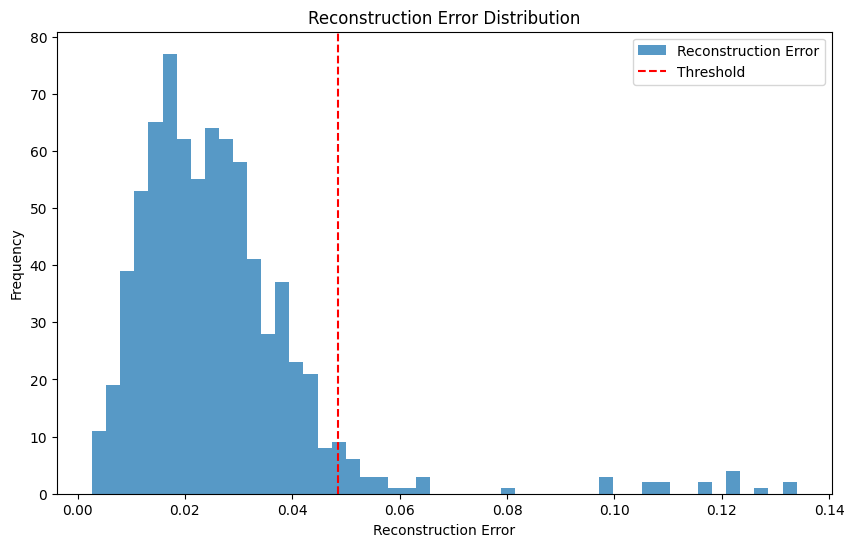

In [ ]:
# Step 7: Visualize reconstruction error
plt.figure(figsize=(10, 6))
plt.hist(reconstruction_errors, bins=50, alpha=0.75, label='Reconstruction Error')
plt.axvline(threshold, color='r', linestyle='--', label='Threshold')
plt.title("Reconstruction Error Distribution")
plt.xlabel("Reconstruction Error")
plt.ylabel("Frequency")
plt.legend()
plt.show()

**Reconstruction Error Analysis**   
*Histogram of Reconstruction Errors:*    
The reconstruction errors for most data points are clustered around lower values, forming a clear peak. The threshold for anomaly detection (0.0485) was determined based on this distribution, likely using a statistical method (e.g., 95th percentile).    
*Threshold and Anomalies:*   
Data points with reconstruction errors exceeding 0.0485 were flagged as anomalies. Number of Anomalies Detected: 39 anomalies were detected in the test dataset. Indices of Anomalies: Specific indices of anomalies include [75, 78, 79, ..., 762]. These can be mapped to timestamps or specific events in the dataset for further analysis.


6. Visualize the results: Plot the original temperature data and highlight the detected
anomalies.

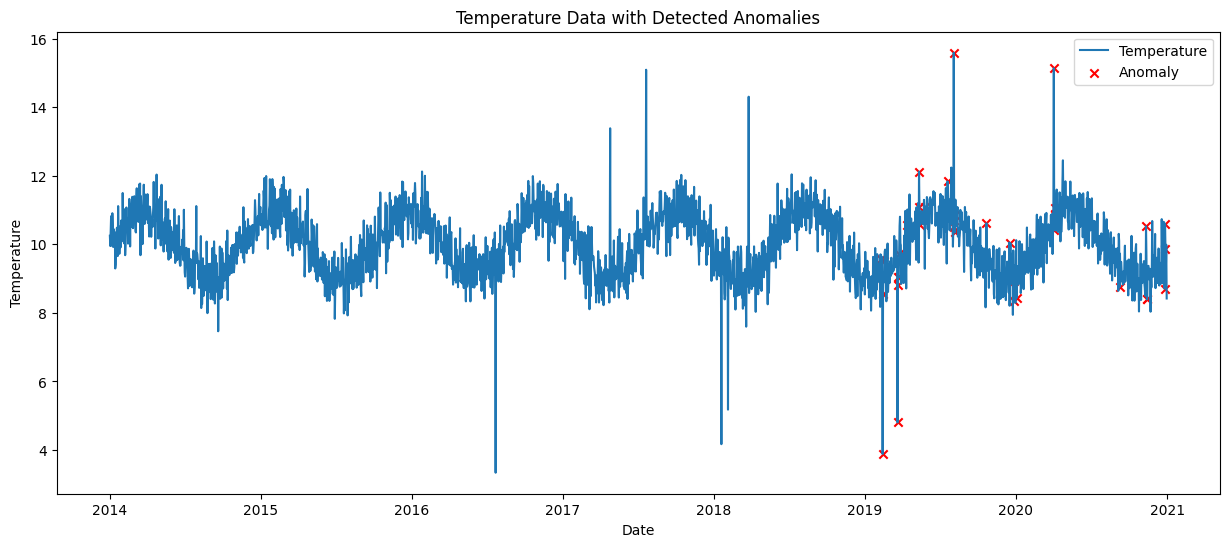

In [ ]:
# Step 6: Visualize the results
plt.figure(figsize=(15, 6))
plt.plot(df.index, df['temperature'], label='Temperature')
plt.scatter(df.index[df['anomaly']], df['temperature'][df['anomaly']], color='red', label='Anomaly', marker='x')
plt.title('Temperature Data with Detected Anomalies')
plt.xlabel('Date')
plt.ylabel('Temperature')
plt.legend()
plt.show()

**Overall Interpretation**   
*Model Performance:*    
The autoencoder model has effectively learned the normal pattern of the temperature data. The low reconstruction errors and stable loss values validate its robustness.

*Anomalies:*   
Detected anomalies likely represent events or conditions that deviate significantly from the usual temperature patterns.
These could be extreme weather events, sensor malfunctions, or unusual environmental conditions.    

*Practical Use:*     
The identified anomalies can be further analyzed to understand their causes.
For instance, if this is environmental monitoring data, the anomalies might represent significant climate events that warrant further investigation.
